# Motion Profiling in VEX Robotics

Motion profiling is a technique used in robotics to plan smooth and efficient movements for a robot. In VEX Robotics, motion profiles help ensure that robots move precisely and quickly while minimizing mechanical stress and wheel slip. This notebook will walk through the basics of motion profiling, focusing on trapezoidal profiles, and demonstrate how to generate and visualize them in Python.

In [35]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter
%matplotlib inline

## Define Robot Motion Constraints

Before generating a motion profile, we need to define the robot's physical constraints. These include maximum velocity, maximum acceleration, and the total distance to travel. These values are based on the robot's hardware and are critical for safe and efficient motion planning.

In [36]:
# Define Robot Motion Constraints
# (Values are typical for a VEX robot, but can be adjusted)

max_velocity = 1.2  # meters per second
max_acceleration = 2.0  # meters per second squared
distance = 2.0  # meters (distance to travel)

time_step = 0.01  # seconds (simulation time step)

## Generate a Trapezoidal Motion Profile

A trapezoidal motion profile consists of three phases: acceleration, constant velocity (cruise), and deceleration. This profile is commonly used in robotics for smooth and efficient movement. Let's calculate the position, velocity, and acceleration at each time step.

In [37]:
# Generate Trapezoidal Motion Profile

def generate_trapezoidal_profile(distance, max_velocity, max_acceleration, time_step):
    # Calculate time to accelerate to max_velocity
    t_accel = max_velocity / max_acceleration
    d_accel = 0.5 * max_acceleration * t_accel**2
    
    # Check if profile is triangular (never reaches max velocity)
    if 2 * d_accel > distance:
        t_accel = np.sqrt(distance / max_acceleration)
        t_cruise = 0
        max_velocity = max_acceleration * t_accel
    else:
        d_cruise = distance - 2 * d_accel
        t_cruise = d_cruise / max_velocity
    
    total_time = 2 * t_accel + t_cruise
    times = np.arange(0, total_time + time_step, time_step)
    positions = []
    velocities = []
    accelerations = []
    
    for t in times:
        if t < t_accel:
            # Acceleration phase
            a = max_acceleration
            v = a * t
            x = 0.5 * a * t**2
        elif t < t_accel + t_cruise:
            # Cruise phase
            a = 0
            v = max_velocity
            x = d_accel + max_velocity * (t - t_accel)
        else:
            # Deceleration phase
            t_decel = t - t_accel - t_cruise
            a = -max_acceleration
            v = max_velocity - max_acceleration * t_decel
            x = d_accel + (t_cruise * max_velocity) + (max_velocity * t_decel) - (0.5 * max_acceleration * t_decel**2)
        positions.append(x)
        velocities.append(v)
        accelerations.append(a)
    return times, np.array(positions), np.array(velocities), np.array(accelerations)

# Generate the profile
times, positions, velocities, accelerations = generate_trapezoidal_profile(distance, max_velocity, max_acceleration, time_step)

## Visualize Position, Velocity, and Acceleration Profiles

Let's plot the position, velocity, and acceleration over time to better understand the motion profile. Visualization helps us see how the robot will move and ensures the profile meets our constraints.

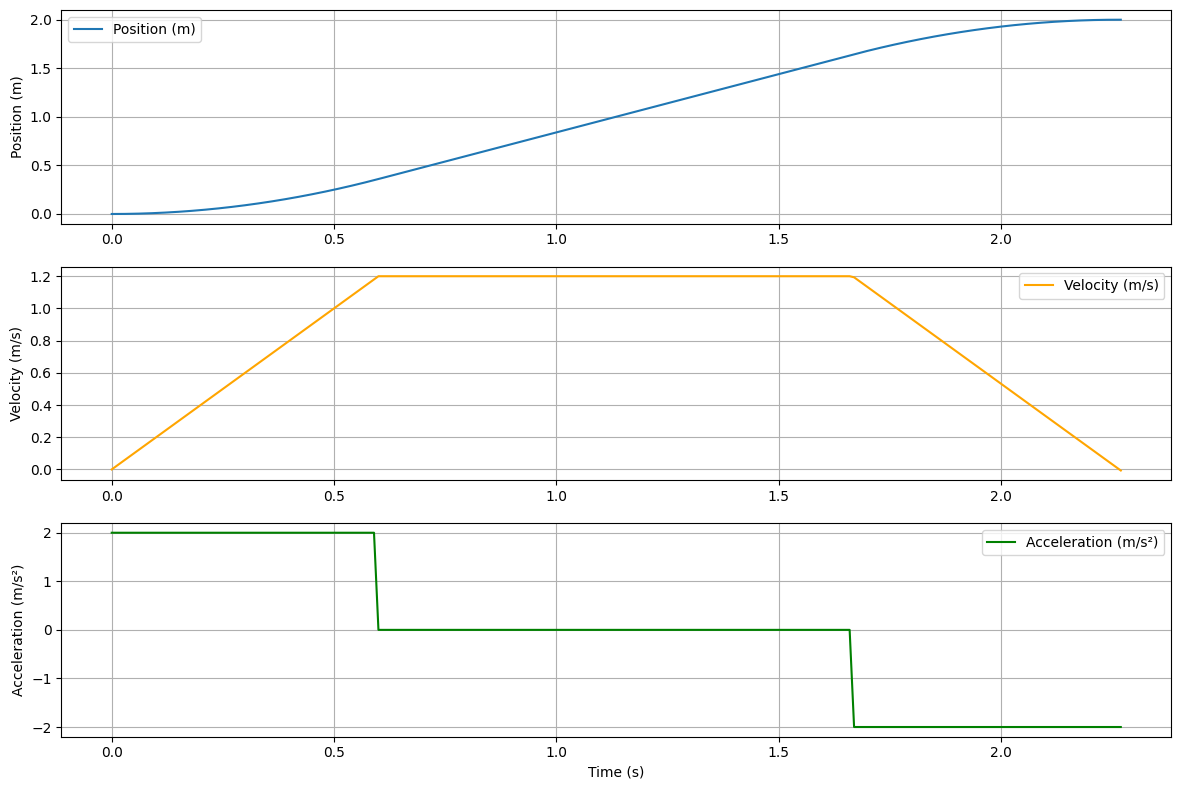

In [38]:
# Plot the motion profile
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(times, positions, label='Position (m)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(times, velocities, label='Velocity (m/s)', color='orange')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(times, accelerations, label='Acceleration (m/s²)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Simulate Robot Following the Motion Profile

Now, let's simulate the robot following the generated motion profile. We'll step through each time interval, updating the robot's position as if it were executing the profile in real time. This helps verify that the profile is feasible for the robot to follow.

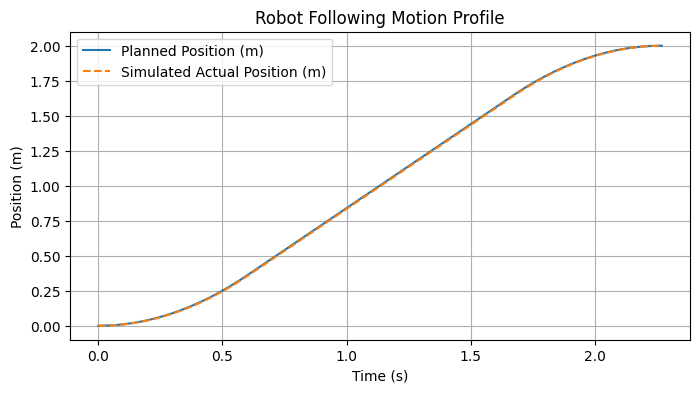

In [39]:
# Simulate robot following the motion profile
actual_positions = [0]
for i in range(1, len(times)):
    # Assume robot perfectly follows the velocity profile
    new_position = actual_positions[-1] + velocities[i-1] * time_step
    actual_positions.append(new_position)

# Plot planned vs. actual position
plt.figure(figsize=(8, 4))
plt.plot(times, positions, label='Planned Position (m)')
plt.plot(times, actual_positions, '--', label='Simulated Actual Position (m)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Robot Following Motion Profile')
plt.legend()
plt.grid(True)
plt.show()

## Limitations of Trapezoidal Motion Profiles and the S-Curve Solution

While trapezoidal motion profiles are simple and effective for many robotics applications, they have some important limitations:

- **Instantaneous Jerk:** Trapezoidal profiles cause sudden changes in acceleration (jerk) at the start and end of acceleration and deceleration phases. This can lead to mechanical stress, wheel slip, and loss of traction, especially at high speeds or with heavy loads.
- **Reduced Smoothness:** The abrupt transitions can make the robot's movement less smooth, which may affect accuracy and repeatability.
- **Increased Wear:** The sharp changes in force can increase wear on motors, gears, and other drivetrain components.

### S-Curve Motion Profiles
S-curve profiles address these issues by gradually ramping up and down the acceleration, resulting in smooth transitions (limited jerk). This provides:
- **Smoother Motion:** Reduces mechanical shock and improves control, especially for precise tasks.
- **Better Traction:** Minimizes wheel slip and helps maintain consistent contact with the field.
- **Lower Mechanical Stress:** Extends the life of robot components by avoiding sudden force changes.

S-curve profiles are more complex to implement but are preferred for high-performance and high-precision robotics applications.

## S-Curve Motion Profile: Math and Example

### What is an S-Curve Profile?
An S-curve motion profile is designed so that acceleration itself changes smoothly, rather than jumping instantly. This means the robot starts moving gently, speeds up smoothly, and then slows down gently—making the position, velocity, and acceleration graphs look like smooth curves.

### The Math
- **Jerk** is the rate of change of acceleration (how quickly acceleration increases or decreases).
- In an S-curve, we limit jerk so acceleration ramps up and down smoothly.
- The profile is made of three main phases:
    1. **Acceleration increases** (jerk is positive)
    2. **Acceleration is constant** (jerk is zero)
    3. **Acceleration decreases** (jerk is negative)

#### Example Equations
Suppose we want to move a robot forward:
- Let `j_max` be the maximum jerk (m/s³)
- Let `a_max` be the maximum acceleration (m/s²)
- Let `v_max` be the maximum velocity (m/s)

For the first phase (acceleration ramp-up):
- Acceleration: `a(t) = j_max * t`
- Velocity: `v(t) = 0.5 * j_max * t²`
- Position: `x(t) = (1/6) * j_max * t³`

After reaching `a_max`, acceleration stays constant, then ramps down at the end.

### Why is this better?
- The robot never experiences a sudden "kick" in acceleration.
- The movement is much smoother, reducing mechanical stress and wheel slip.

Let's see an example S-curve profile in code and graph it!

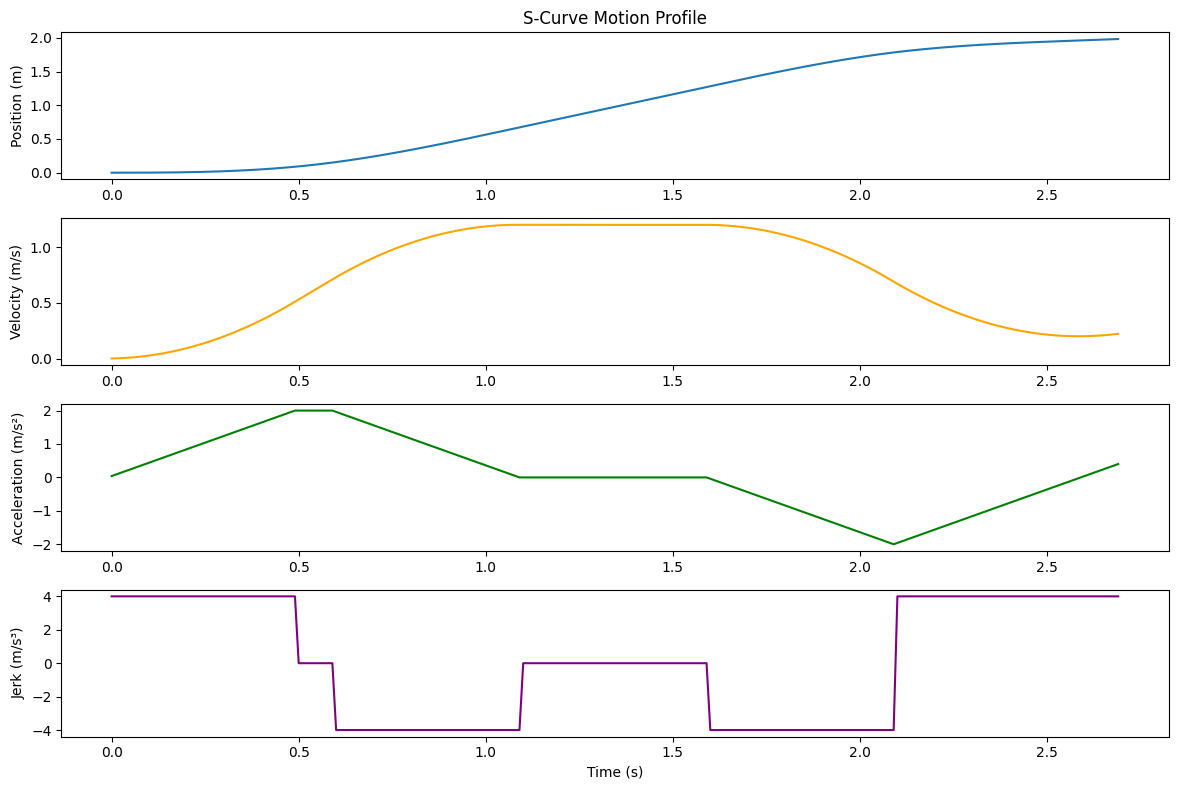

In [40]:
# Improved S-Curve Motion Profile (Standard 7-Segment, No Mirroring Artifacts)
import numpy as np
import matplotlib.pyplot as plt

# Parameters (same as trapezoidal)
j_max = 4.0      # max jerk (m/s^3)
a_max = 2.0      # max acceleration (m/s^2)
v_max = 1.2      # max velocity (m/s)
distance = 2.0   # meters
dt = 0.01

# Calculate time for jerk and acceleration phases
tj = a_max / j_max
Ta = v_max / a_max  # time at max acceleration
# Estimate total move time (accel + cruise + decel)
# For a full S-curve, cruise time is adjusted to hit the target distance
# Calculate distance covered during accel/decel (s-curve) phases
s_accel = a_max * tj**2 + a_max * (Ta - tj)
s_profile = 2 * s_accel
s_cruise = distance - s_profile
if s_cruise < 0:
    # No cruise phase, recalculate for triangular profile
    Ta = np.sqrt(distance / a_max)
    s_accel = distance / 2
    s_cruise = 0
    t_cruise = 0
else:
    t_cruise = s_cruise / v_max
T_total = 2 * (Ta + tj) + t_cruise

# Precompute the profile
times = np.arange(0, T_total, dt)
positions = []
velocities = []
accelerations = []
jerks = []

x = 0
v = 0
a = 0
for t in times:
    # 7-segment S-curve profile
    if t < tj:
        j = j_max
    elif t < Ta:
        j = 0
    elif t < Ta + tj:
        j = -j_max
    elif t < Ta + tj + t_cruise:
        j = 0
    elif t < Ta + tj + t_cruise + tj:
        j = -j_max
    elif t < Ta + 2 * tj + t_cruise:
        j = 0
    elif t < T_total:
        j = j_max
    else:
        j = 0
    a += j * dt
    # Clamp acceleration
    if a > a_max:
        a = a_max
    if a < -a_max:
        a = -a_max
    v += a * dt
    # Clamp velocity
    if v > v_max:
        v = v_max
    if v < 0:
        v = 0
    x += v * dt
    # Clamp position to not overshoot
    if x > distance:
        x = distance
    positions.append(x)
    velocities.append(v)
    accelerations.append(a)
    jerks.append(j)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(times, positions, label='Position (m)', color='C0')
plt.ylabel('Position (m)')
plt.title('S-Curve Motion Profile')
plt.subplot(4, 1, 2)
plt.plot(times, velocities, label='Velocity (m/s)', color='orange')
plt.ylabel('Velocity (m/s)')
plt.subplot(4, 1, 3)
plt.plot(times, accelerations, label='Acceleration (m/s²)', color='green')
plt.ylabel('Acceleration (m/s²)')
plt.subplot(4, 1, 4)
plt.plot(times, jerks, label='Jerk (m/s³)', color='purple')
plt.ylabel('Jerk (m/s³)')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()